# Modified Mobility Patterns

#### Primary Authors:
Chris Carey, Maia Guo

#### Description:
This notebook modified the mobility_pattern_with_cluster notebook to produce time plots.

#### Inputs:
```
exports/home_weekly.csv
```

#### Visualizations:
> Time-series plot total food location visitations

In [1]:
import numpy as np
import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt 
import json
%pylab inline 
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls ../share/data/processed/

brand_info_food.csv	       poi_weekly_20211029.csv
cbg_attr_and_cluster_1009.csv  social_distancing_nyc.csv
cbg_attr_and_cluster_1021.csv  weekly_and_core.csv
cbg_distance_matrix.csv        weekly_and_core_with_area.csv
files			       weekly_brand_info.csv
home_weekly_20211029.csv       weekly_patterns_with_general_info.csv
placekey_and_area.csv	       weekly_trips_20211017.csv
poi_info.csv		       weekly_trips_by_cbg.csv


In [102]:
# First week of 2019.
DATE_START = pd.to_datetime('2018-12-31 00:00:00-05:00')
# Last week of 2020.
DATE_END = pd.to_datetime('2020-01-25 00:00:00-05:00')

# First week of 2020.
DATE_START_PLOT = pd.to_datetime('2019-12-30 00:00:00-05:00')
# CUTOFF BEFORE DATA GAP
DATE_END_PLOT = pd.to_datetime('2020-11-23 00:00:00-05:00')

# Start of COVID-19 Pre-Pandemic Period
DATE_START_PRE_COVID = pd.to_datetime('2019-03-18 00:00:00-05:00')
DATE_END_PRE_COVID = pd.to_datetime('2019-11-25 00:00:00-05:00')

# Start of COVID-19 Pre-Pandemic Period -/+ 1 week
DATE_START_PRE_COVID_ROLLING = pd.to_datetime('2019-03-11 00:00:00-05:00')
DATE_END_PRE_COVID_ROLLING = pd.to_datetime('2019-12-02 00:00:00-05:00')

# Start of COVID-19 Pandemic Period
DATE_START_COVID_ROLLING = pd.to_datetime('2020-03-16 00:00:00-05:00')
DATE_END_COVID_ROLLING = pd.to_datetime('2020-11-23 00:00:00-05:00')

# Start of COVID-19 Pandemic Period -/+ 1 week
DATE_START_COVID_ROLLING = pd.to_datetime('2020-03-09 00:00:00-05:00')
DATE_END_COVID_ROLLING = pd.to_datetime('2020-11-30 00:00:00-05:00')

# First week of 2019 - 1 week.
DATE_START_ROLLING = pd.to_datetime('2018-12-24 00:00:00-05:00')
# Last week of 2020 + 1 week.
DATE_END_ROLLING = pd.to_datetime('2021-02-01 00:00:00-05:00')

In [78]:
# https://cran.r-project.org/web/packages/khroma/vignettes/tol.html + NYU
COLORS = [
    '#57068c', '#e0b6fc', '#825', '#173', '#dc7', '#4a9', '#c67', '#993', '#a49']
LINE_STYLES = [
    'solid',
    'dashed',
    (0, (1, 1)),
    'dashdot',
    'solid',
    (0, (5, 1)),
    (0, (3, 1, 1, 1, 1, 1)),
    'dashed',
    'dashdot',
]

In [150]:
FONT_SIZE_TICKS=13
FONT_SIZE_AXIS=14
FONT_SIZE_TITLE=16
FONT_SIZE_LEGEND=14

In [79]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [88]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [80]:
cluster_attr = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
clusters = cluster_attr[['census_block_group', 'Cluster']].set_index('census_block_group')
clusters.head()

,Cluster
census_block_group,
360050001001,2
360050002001,2
360050002002,2
360050002003,3
360050004001,3


In [81]:
poi = pd.read_csv('./exports/poi_health_recategorized.csv')

In [82]:
#poiHealth.category.unique()

In [83]:
other_retail = [
    'Beer, Wine, and Liquor Stores',
    'Big Box Grocers',
    #'Delis and Convenience Stores',
    'Food Services',
    'General Merchandise Stores',
    'Specialty Food Stores',
    'Tobacco Stores',
]

other_service = [
    'Drinking Places',
    'Snacks and Bakeries',
]

In [84]:
poi['combined_category'] = poi['category']
poi.loc[poi['category'].isin(other_retail), 'combined_category'] = 'Other Food Retail'
poi.loc[poi['category'].isin(other_service), 'combined_category'] = 'Other Food Service'

In [85]:
poi.columns

Index(['placekey', 'cbg', 'naics_code', 'category', 'sub_category',
       'location_name', 'area_square_feet', 'latitude', 'longitude',
       'combined_category'],
      dtype='object')

In [86]:
categories = poi[['placekey', 'category', 'combined_category', 'cbg']]
categories.head()

,placekey,category,combined_category,cbg
0,222-222@627-s94-nwk,Specialty Food Stores,Other Food Retail,360470395002
1,223-222@627-rw6-zfz,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360050386008
2,223-222@627-rwq-vcq,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360050117001
3,223-222@627-sb5-8jv,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360810107011
4,223-222@627-tkd-fvf,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360811032021


In [87]:
trips = pd.read_csv('./exports/home_weekly.csv')
trips = trips.merge(categories, on='placekey')
trips = trips.merge(clusters, left_on='home_cbg', right_on='census_block_group')
trips.head(3)

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,category,combined_category,cbg,Cluster
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,20.076046,Full-Service Restaurants,Full-Service Restaurants,360471194001,2
1,223-222@627-wg7-7h5,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,25.872502,Fast Food Restaurants,Fast Food Restaurants,360470930002,2
2,22v-222@627-wg4-t5f,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,22.579698,Full-Service Restaurants,Full-Service Restaurants,360470828002,2


In [89]:
repair_dates(trips)
trips['date'] = trips.date_range_start.dt.date
trips['year'] = trips.date_range_start.dt.year
trips['month'] = trips.date_range_start.dt.month

In [90]:
max(trips.date_range_start)

Timestamp('2021-02-15 00:00:00-0500', tz='US/Eastern')

In [91]:
# set the figure and font size
#import seaborn as sns 
import matplotlib.ticker as mtick
#sns.set(rc={"font.size":18, "axes.titlesize":18, "axes.labelsize":16}) # 'figure.figsize':(20, 8), 
#sns.reset_orig()

### POI Count per Capita by category

In [92]:
# home POI Count

In [93]:
def get_count_and_pct_df(df, pop, column_label):
    
    Count = df[['placekey', column_label, 'Cluster']].groupby(['Cluster', column_label]).count()
    Count = pd.pivot_table(Count, values='placekey', index=['Cluster'], columns=[column_label])
    for i in Count.columns:
        Count[i] = Count[i] / pop['Total Population'] * 1000 # per 1000 capita
    
    Pct = Count.copy()
    for i in Pct.columns:
        Pct[i] = Pct[i]/Count.sum(axis=1)
    
    return Count, Pct

In [94]:
#homepoi = categories.merge(clusters, left_on='cbg', right_on='census_block_group')
#clPop = cluster_attr[['Cluster', 'Total Population']].groupby('Cluster').sum()
#poiCount, poiPct = get_count_and_pct_df(homepoi, clPop, 'combined_category')

In [95]:
def poi_plots(count_df, pct_df, which_type):
    
    fig, ax = plt.subplots(1,2,figsize=(18,5))

    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap(i / 20) for i in range(0, 20)]

    count_df.plot.bar(color=colors, ax=ax[0])
    ax[0].set(xlabel='Clusters', ylabel='Number per 1000 Capita', title='%s POI Count per 1000 Capita' % which_type, xticks=count_df.index)
    ax[0].tick_params(axis='x', rotation=0, size=18)
    ax[0].get_legend().remove()

    for i in range(pct_df.shape[1]):
        if i == 0:
            ax[1].bar(pct_df.index, pct_df.iloc[:, i], width=0.75, color=colors[i], label=pct_df.columns[i], alpha=0.8)
        else:
            ax[1].bar(pct_df.index, pct_df.iloc[:, i], bottom=np.sum(pct_df.iloc[:, :i], axis=1), 
                      width=0.75, color=colors[i], label=pct_df.columns[i], alpha=0.8)
    ax[1].set(xlabel='Clusters', ylabel='Percentage', title='%s POI Category Composition' % which_type, xticks=pct_df.index)
    ax[1].legend(bbox_to_anchor=(0.45, -0.25, 0.1, 0.1), ncol=4, loc='lower center', 
                  bbox_transform=fig.transFigure, fontsize=15)
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [103]:
trip2019 = trips[(trips['date_range_start'] >= DATE_START_PRE_COVID_ROLLING) & (trips['date_range_start'] <= DATE_END_PRE_COVID_ROLLING)]
trip2020 = trips[(trips['date_range_start'] >= DATE_START_COVID_ROLLING) & (trips['date_range_start'] <= DATE_END_COVID_ROLLING)]

### Estimated visitor count by category

### Time-series /Cluster /Category

In [132]:
tp19 = trip2019[['date_range_start', 'estimated_visitor_count', 'combined_category', 'Cluster']]

tp19 = tp19.groupby(['combined_category', 'Cluster', 'date_range_start'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp19_total = tp19.groupby(['Cluster', 'date_range_start'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp19_total = tp19_total.rename(columns={'estimated_visitor_count': 'estimated_visitor_total'})
tp19 = tp19.merge(tp19_total, on=['Cluster', 'date_range_start'], how='inner')
tp19['proportion'] = tp19['estimated_visitor_count'] / tp19['estimated_visitor_total']
tp19 = pd.pivot_table(tp19, values='proportion', index=['date_range_start'], columns=['combined_category', 'Cluster'])
tp19 = tp19.sort_values(by=['date_range_start'])
tp19[tp19.columns] = tp19[tp19.columns].rolling(3, center=True).mean()
tp19 = tp19[(tp19.index >= DATE_START_PRE_COVID) & (tp19.index <= DATE_END_PRE_COVID)]
tp19 = tp19.reset_index(drop=True)
peek(tp19)

combined_category Delis and Convenience Stores                                \
Cluster                                      0         1         2         3   
0                                     0.042307  0.029221  0.047820  0.035778   
1                                     0.041797  0.029155  0.048347  0.035909   
2                                     0.041623  0.029593  0.048713  0.036090   

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
0                              0.148557  0.106472  0.130044  0.118265   
1                              0.148583  0.107119  0.128919  0.118371   
2                              0.148210  0.107656  0.129287  0.117726   

combined_category Full-Service Restaurants            ... Other Food Service  \
Cluster                                  0         1  ...                  2   
0                                 0.353329  0.366027  ...           0.137359   
1                                 0.352609  0.365799  ...           0.137269   
2                                 0.352511  0.366345  ...           0.136564   

combined_category           Pharmacies and Drug Stores                      \
Cluster                   3                          0         1         2   
0                  0.157013                   0.064123  0.038822  0.070107   
1                  0.156868                   0.064668  0.038125  0.071377   
2                  0.155158                   0.065301  0.038616  0.070920   

combined_category           Supermarkets and Grocery Stores            \
Cluster                   3                               0         1   
0                  0.058171                        0.066658  0.038063   
1                  0.058018                        0.066353  0.038366   
2                  0.057792                        0.067243  0.039177   

combined_category                      
Cluster                   2         3  
0                  0.067920  0.059372  
1                  0.068213  0.059724  
2                  0.069390  0.060078  

[3 rows x 32 columns]

36


In [133]:
tp20 = trip2020[['date_range_start', 'estimated_visitor_count', 'combined_category', 'Cluster']]

tp20 = tp20.groupby(['combined_category', 'Cluster', 'date_range_start'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp20_total = tp20.groupby(['Cluster', 'date_range_start'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp20_total = tp20_total.rename(columns={'estimated_visitor_count': 'estimated_visitor_total'})
tp20 = tp20.merge(tp20_total, on=['Cluster', 'date_range_start'], how='inner')
tp20['proportion'] = tp20['estimated_visitor_count'] / tp20['estimated_visitor_total']
tp20 = pd.pivot_table(tp20, values='proportion', index=['date_range_start'], columns=['combined_category', 'Cluster'])
tp20 = tp20.sort_values(by=['date_range_start'])
tp20[tp20.columns] = tp20[tp20.columns].rolling(3, center=True).mean()
tp20 = tp20[(tp20.index >= DATE_START_COVID) & (tp20.index <= DATE_END_COVID)]
tp20 = tp20.reset_index(drop=True)
peek(tp20)

combined_category Delis and Convenience Stores                                \
Cluster                                      0         1         2         3   
0                                     0.043351  0.036130  0.050264  0.041960   
1                                     0.043689  0.036182  0.050643  0.042753   
2                                     0.044248  0.035952  0.049239  0.042771   

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
0                              0.147515  0.105739  0.125478  0.114001   
1                              0.154357  0.107972  0.128031  0.119046   
2                              0.159502  0.110838  0.130467  0.123452   

combined_category Full-Service Restaurants            ... Other Food Service  \
Cluster                                  0         1  ...                  2   
0                                 0.314853  0.328390  ...           0.106178   
1                                 0.314331  0.327154  ...           0.100547   
2                                 0.311244  0.323356  ...           0.099096   

combined_category           Pharmacies and Drug Stores                      \
Cluster                   3                          0         1         2   
0                  0.119207                   0.085564  0.064737  0.085165   
1                  0.114731                   0.086458  0.064691  0.085438   
2                  0.110685                   0.086983  0.065620  0.086214   

combined_category           Supermarkets and Grocery Stores            \
Cluster                   3                               0         1   
0                  0.082725                        0.116150  0.100937   
1                  0.084880                        0.116551  0.104704   
2                  0.084629                        0.117529  0.107098   

combined_category                      
Cluster                   2         3  
0                  0.115658  0.118980  
1                  0.120170  0.124121  
2                  0.121349  0.124588  

[3 rows x 32 columns]

36


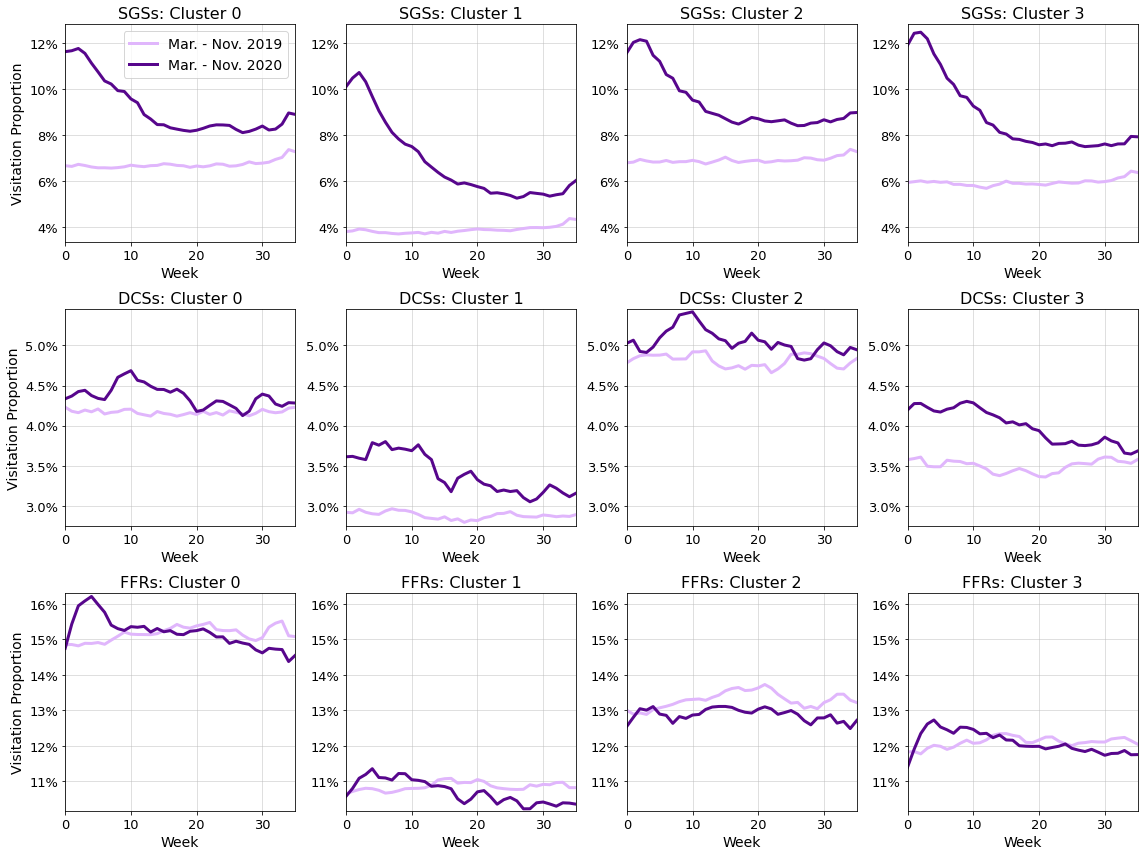

In [186]:
plot_categories = [
    tp20.columns.levels[0][7],
    tp20.columns.levels[0][0],
    tp20.columns.levels[0][1],
]

category_names = ['SGSs', 'DCSs', 'FFRs']

s = 4
fig, ax = plt.subplots(len(plot_categories), 4, figsize=(s * 4, s * len(plot_categories)))

    #fig.suptitle('Visitation for %s ' % category,
    #             fontsize=16,
    #             verticalalignment='top')
for i, category in enumerate(plot_categories):

    min_y = 1
    max_y = 0

    for cl in range(4):
        tp19[(category, cl)].plot(ax=ax[i, cl], label='Mar. - Nov. 2019', legend=(i==0 and cl==0), color=COLORS[1], linewidth=3)
        tp20[(category, cl)].plot(ax=ax[i, cl], label='Mar. - Nov. 2020', legend=(i==0 and cl==0), color=COLORS[0], linewidth=3)
        ax[i, cl].set_title(f'{category_names[i]}: Cluster {cl}', fontsize=FONT_SIZE_TITLE)
        min_y = min(min_y, ax[i, cl].get_ylim()[0])
        max_y = max(max_y, ax[i, cl].get_ylim()[1])

        ax[i, cl].grid(color='#bdbdbd', alpha=0.6, zorder=1)

    for cl in range(4):
        ax[i, cl].set_xlim([0, len(tp20) - 1])
        ax[i, cl].set_xlabel('Week', fontsize=FONT_SIZE_AXIS)
        ax[i, cl].set_ylim([min_y, max_y])
        ax[i, cl].tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
        ax[i, cl].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
        ax[i, cl].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=(1 if i == 1 else 0)))
        ax[i, 0].set_ylabel('Visitation Proportion', fontsize=FONT_SIZE_AXIS)
        
    if i == 0:
        ax[0, 0].legend(fontsize=FONT_SIZE_LEGEND)

plt.tight_layout()
plt.show()